## EDA

Basic Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4269 entries, 0 to 4268
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   loan_id                   4269 non-null   int64 
 1   no_of_dependents          4269 non-null   int64 
 2   education                 4269 non-null   object
 3   self_employed             4269 non-null   object
 4   income_annum              4269 non-null   int64 
 5   loan_amount               4269 non-null   int64 
 6   loan_term                 4269 non-null   int64 
 7   cibil_score               4269 non-null   int64 
 8   residential_assets_value  4269 non-null   int64 
 9   commercial_assets_value   4269 non-null   int64 
 10  luxury_assets_value       4269 non-null   int64 
 11  bank_asset_value          4269 non-null   int64 
 12  loan_status               4269 non-null   object
dtypes: int64(10), object(3)
memory usage: 433.7+ KB
None


Miss

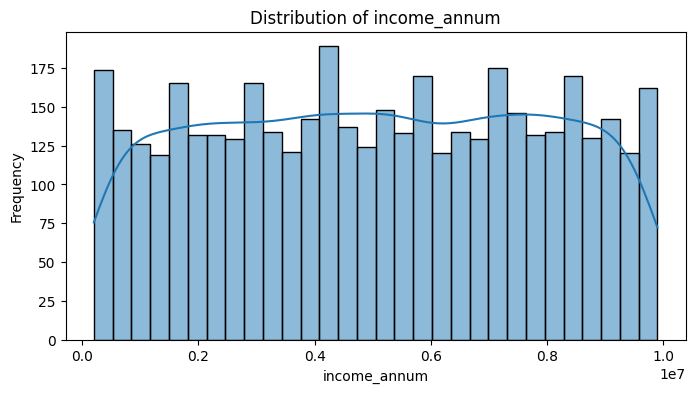

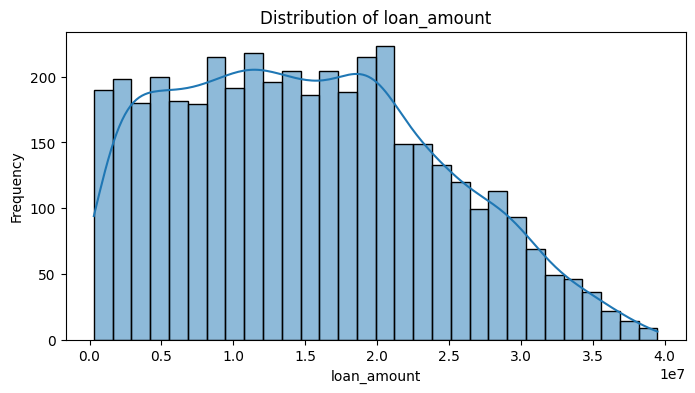

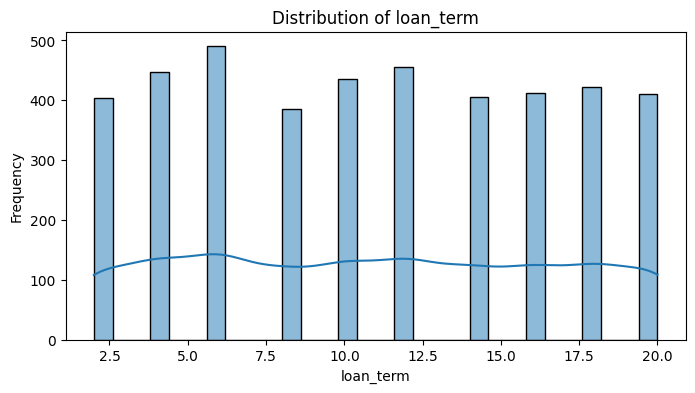

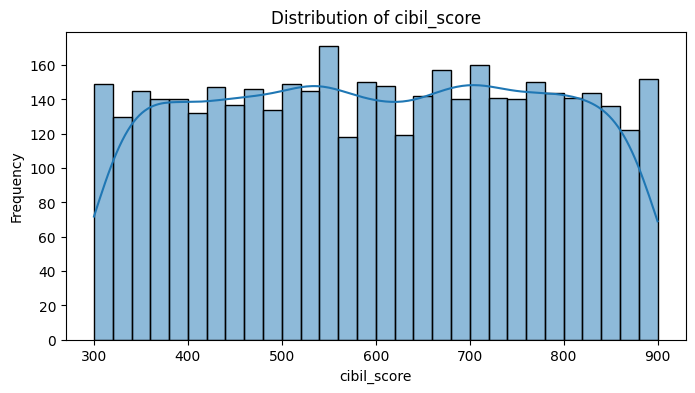

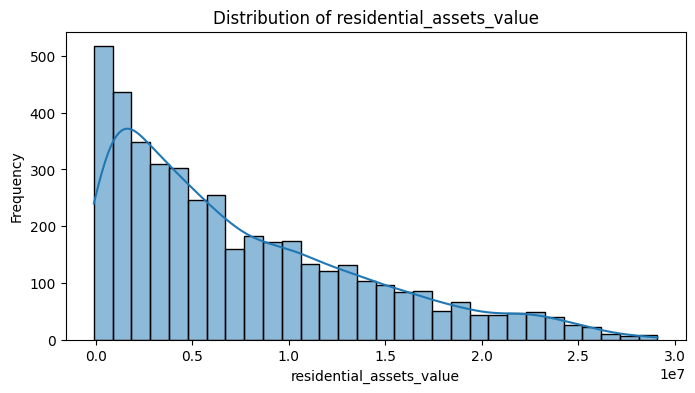

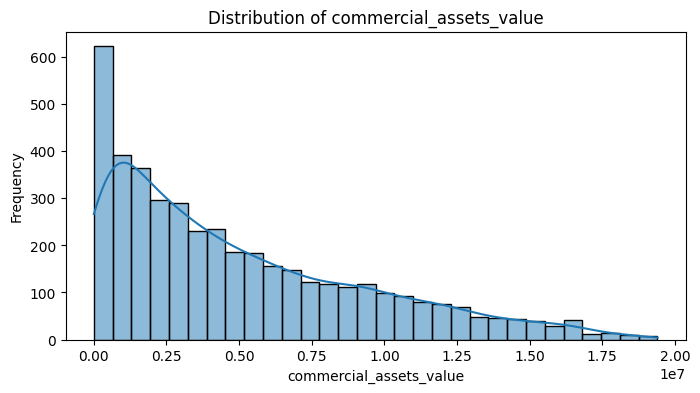

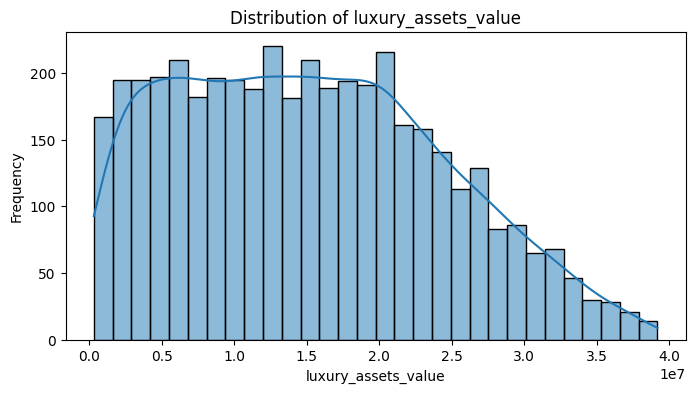

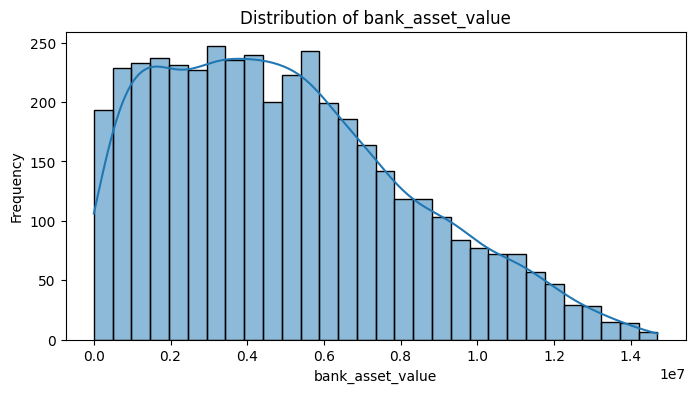

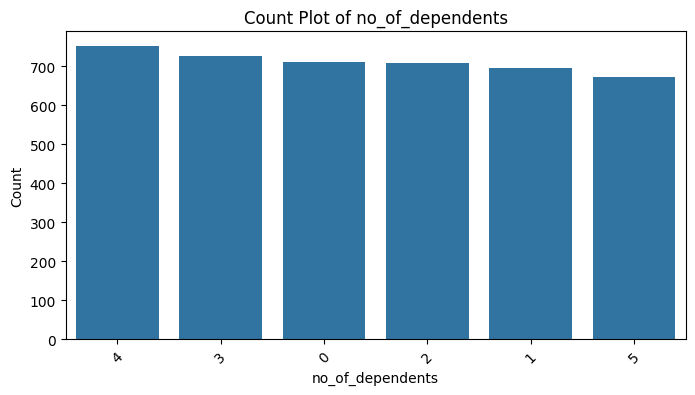

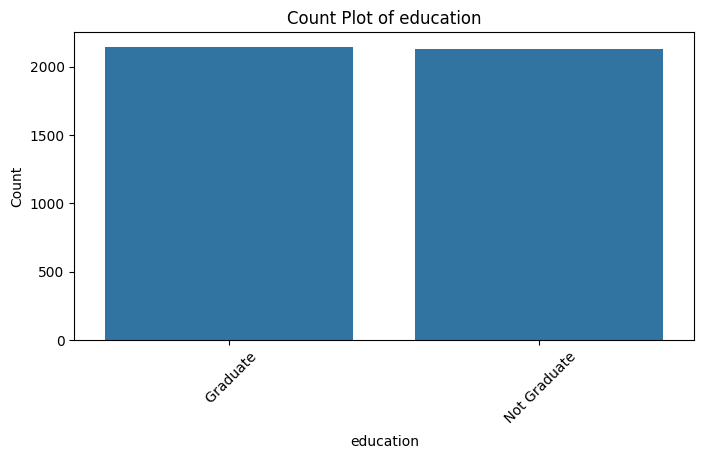

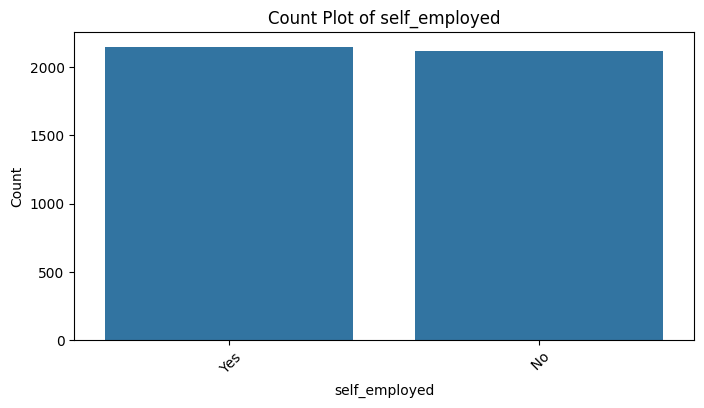

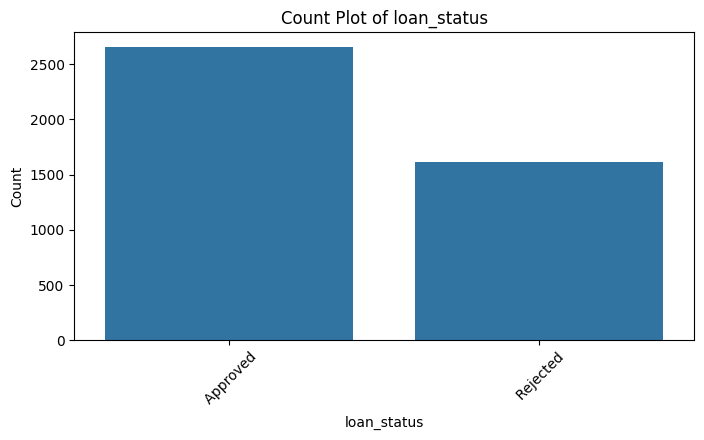

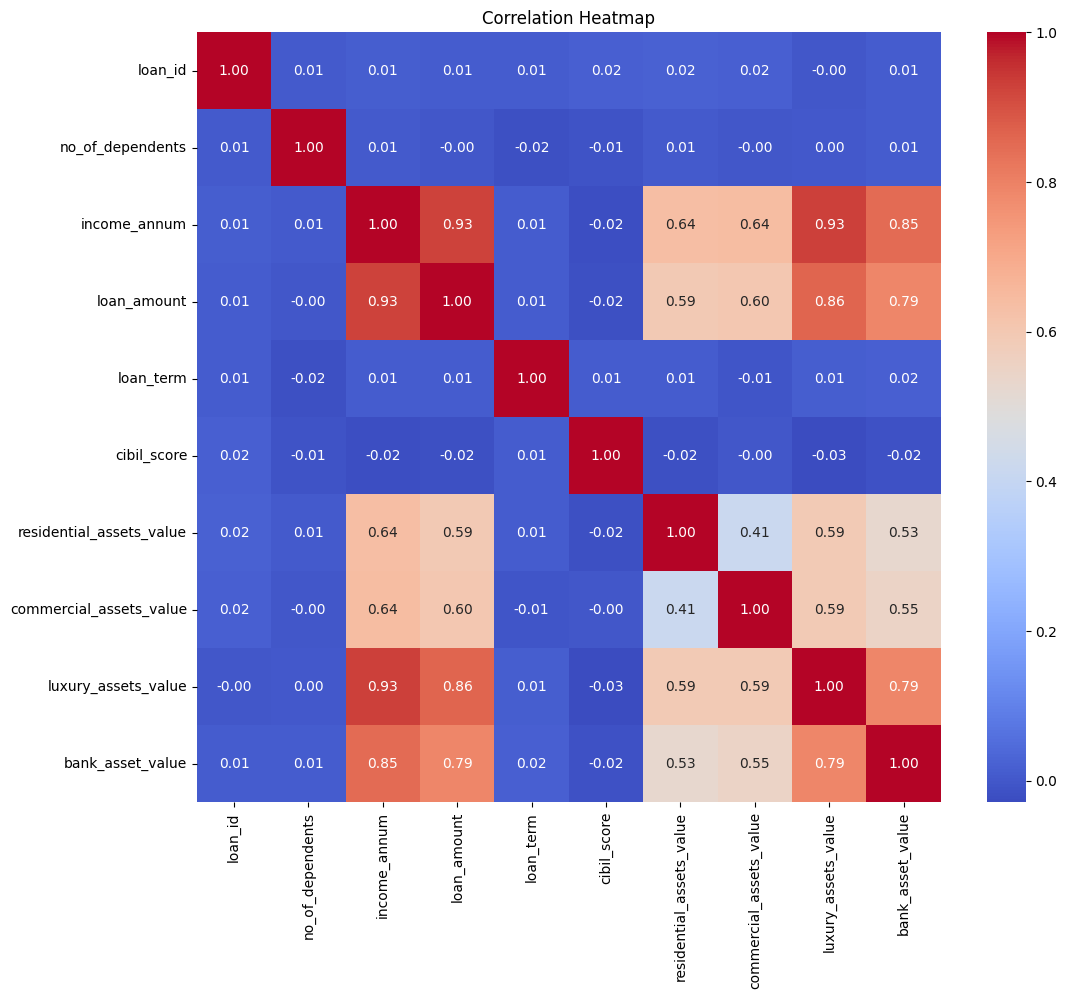

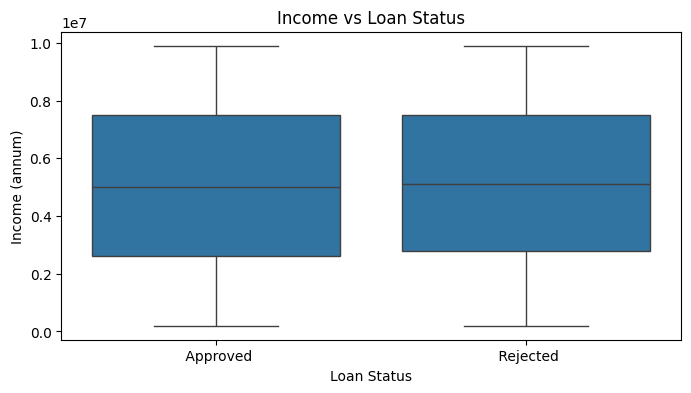

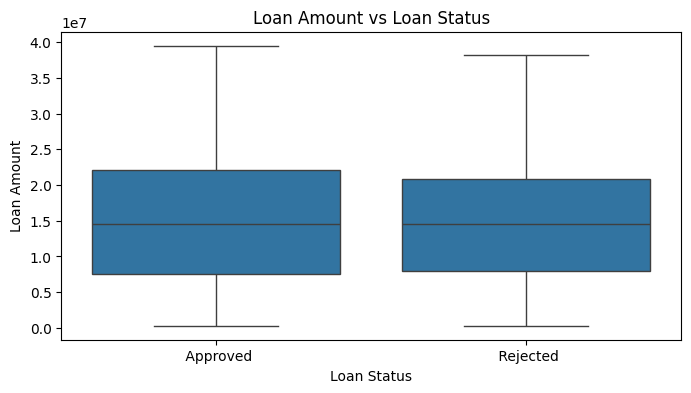

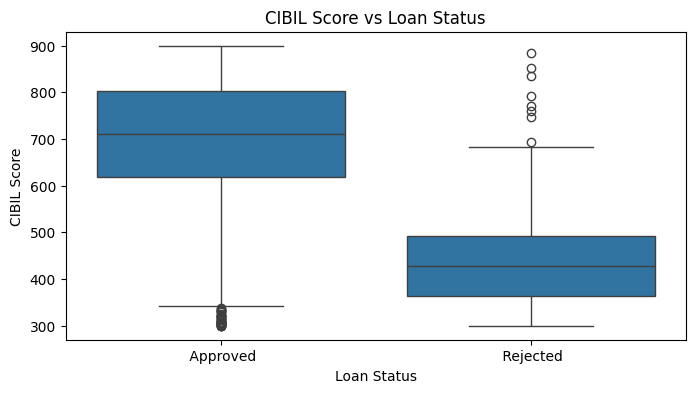

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
data = pd.read_csv('loan_approval_dataset.csv')  # Replace with your dataset filename

# Strip leading/trailing whitespaces from column names
data.columns = data.columns.str.strip()

# Basic Information
print("Basic Information:")
print(data.info())
print("\n")

# Check for missing values
print("Missing Values:")
print(data.isnull().sum())
print("\n")

# Descriptive Statistics
print("Descriptive Statistics:")
print(data.describe())
print("\n")

# Distribution of numerical features
numerical_features = [
    'income_annum', 'loan_amount', 'loan_term', 'cibil_score',
    'residential_assets_value', 'commercial_assets_value',
    'luxury_assets_value', 'bank_asset_value'
]

for feature in numerical_features:
    plt.figure(figsize=(8, 4))
    sns.histplot(data[feature], kde=True, bins=30)
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.show()

# Count plots for categorical features
categorical_features = ['no_of_dependents', 'education', 'self_employed', 'loan_status']

for feature in categorical_features:
    plt.figure(figsize=(8, 4))
    sns.countplot(data=data, x=feature, order=data[feature].value_counts().index)
    plt.title(f'Count Plot of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.show()

# Correlation Heatmap (Only numeric columns)
numeric_data = data.select_dtypes(include=['number'])
plt.figure(figsize=(12, 10))
corr_matrix = numeric_data.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

# Boxplots to examine relationships
plt.figure(figsize=(8, 4))
sns.boxplot(data=data, x='loan_status', y='income_annum')
plt.title('Income vs Loan Status')
plt.xlabel('Loan Status')
plt.ylabel('Income (annum)')
plt.show()

plt.figure(figsize=(8, 4))
sns.boxplot(data=data, x='loan_status', y='loan_amount')
plt.title('Loan Amount vs Loan Status')
plt.xlabel('Loan Status')
plt.ylabel('Loan Amount')
plt.show()

plt.figure(figsize=(8, 4))
sns.boxplot(data=data, x='loan_status', y='cibil_score')
plt.title('CIBIL Score vs Loan Status')
plt.xlabel('Loan Status')
plt.ylabel('CIBIL Score')
plt.show()


## model building

In [17]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import classification_report, mean_absolute_error

# Load the dataset
data = pd.read_csv('loan_approval_dataset.csv')  # Replace with your dataset filename

# Strip leading/trailing whitespaces from column names
data.columns = data.columns.str.strip()

# Encode `loan_status` for classification (Approved -> 1, Rejected -> 0)
data['loan_status_encoded'] = data['loan_status'].apply(lambda x: 1 if x.strip() == 'Approved' else 0)

# Define features and targets for both tasks
X = data.drop(columns=['loan_id', 'loan_status', 'loan_status_encoded', 'loan_term'])
y_classification = data['loan_status_encoded']  # Target for confidence of repayment
y_regression = data['loan_term']  # Target for years to clear the loan

# Identify categorical and numerical features
categorical_features = ['education', 'self_employed']
numerical_features = [
    'no_of_dependents', 'income_annum', 'loan_amount', 'cibil_score',
    'residential_assets_value', 'commercial_assets_value',
    'luxury_assets_value', 'bank_asset_value'
]

# Clean categorical features by stripping leading/trailing spaces
for col in categorical_features:
    data[col] = data[col].str.strip()

# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_features)
    ])

# Split the data for classification
X_train_class, X_test_class, y_train_class, y_test_class = train_test_split(
    X, y_classification, test_size=0.2, random_state=42
)

# Classification: Predict confidence of repayment
classification_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])
classification_pipeline.fit(X_train_class, y_train_class)
y_pred_class = classification_pipeline.predict(X_test_class)
y_pred_class_prob = classification_pipeline.predict_proba(X_test_class)[:, 1]

# Classification Report
print("Classification Report:")
print(classification_report(y_test_class, y_pred_class))

# Split the data for regression
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X, y_regression, test_size=0.2, random_state=42
)

# Regression: Predict how many years to clear the loan
regression_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42))
])
regression_pipeline.fit(X_train_reg, y_train_reg)
y_pred_reg = regression_pipeline.predict(X_test_reg)

# Regression Error
mae = mean_absolute_error(y_test_reg, y_pred_reg)
print(f"Mean Absolute Error for Regression (Loan Term): {mae:.2f}")

# Example input for prediction
example_input = pd.DataFrame([{
    'no_of_dependents': 2,
    'education': 'Not Graduate',
    'self_employed': 'No',
    'income_annum': 9600000,
    'loan_amount': 29900000,
    'cibil_score': 778,
    'residential_assets_value': 2400000,
    'commercial_assets_value': 17600000,
    'luxury_assets_value': 22700000,
    'bank_asset_value': 8000000
}])

# Predict confidence of repayment
confidence = classification_pipeline.predict_proba(example_input)[:, 1][0]
print(f"Confidence of repayment: {confidence:.2f}")

# Predict years to clear the loan
years_to_clear = regression_pipeline.predict(example_input)[0]
print(f"Predicted years to clear the loan: {years_to_clear:.2f}")


Classification Report:
              precision    recall  f1-score   support

           0       0.90      1.00      0.94       318
           1       1.00      0.93      0.96       536

    accuracy                           0.96       854
   macro avg       0.95      0.96      0.95       854
weighted avg       0.96      0.96      0.96       854

Mean Absolute Error for Regression (Loan Term): 4.94
Confidence of repayment: 0.99
Predicted years to clear the loan: 12.12


c:\Users\60165\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\60165\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


## Feature Importance

Feature Importances:
                    Feature  Importance
3               cibil_score    0.816389
2               loan_amount    0.035144
6       luxury_assets_value    0.027558
4  residential_assets_value    0.026332
1              income_annum    0.024712
5   commercial_assets_value    0.024541
7          bank_asset_value    0.023608
0          no_of_dependents    0.013180
9        self_employed_ Yes    0.004507
8   education_ Not Graduate    0.004028


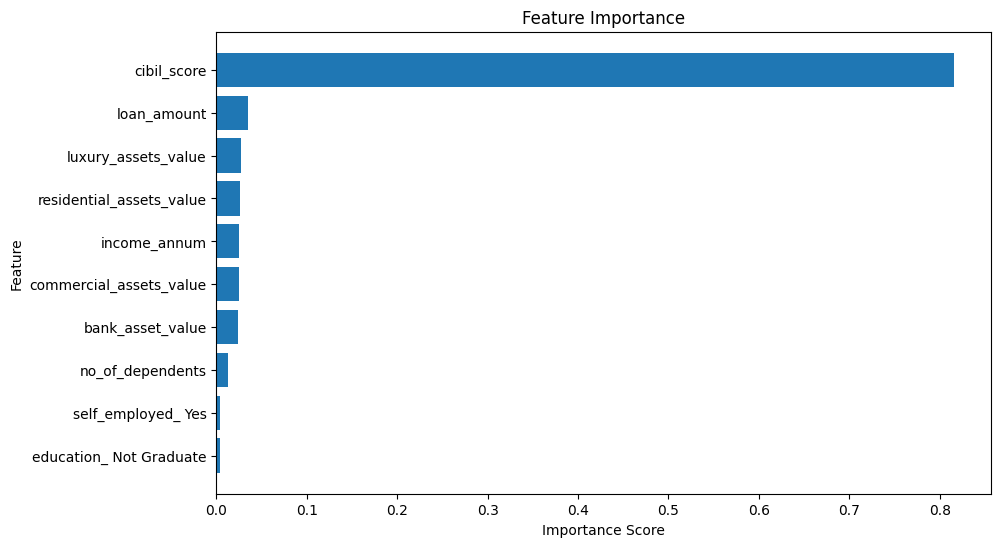

In [18]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Load the dataset
data = pd.read_csv('loan_approval_dataset.csv')  # Replace with your dataset filename

# Strip leading/trailing whitespaces from column names
data.columns = data.columns.str.strip()

# Encode `loan_status` for classification (Approved -> 1, Rejected -> 0)
data['loan_status_encoded'] = data['loan_status'].apply(lambda x: 1 if x.strip() == 'Approved' else 0)

# Define features and target
X = data.drop(columns=['loan_id', 'loan_status', 'loan_status_encoded', 'loan_term'])
y = data['loan_status_encoded']  # Target for confidence of repayment

# Clean categorical features by stripping leading/trailing spaces
categorical_features = ['education', 'self_employed']
for col in categorical_features:
    data[col] = data[col].str.strip()

# Convert categorical features to one-hot encoding
X = pd.get_dummies(X, columns=categorical_features, drop_first=True)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Random Forest model
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

# Get feature importance scores
feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Display the feature importances
print("Feature Importances:")
print(feature_importances)

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importances['Feature'], feature_importances['Importance'])
plt.gca().invert_yaxis()
plt.title('Feature Importance')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.show()


## testing with lowest cibil (credit) score

In [23]:
# Example input for prediction
example_input = pd.DataFrame([{
    'no_of_dependents': 2,
    'education': 'Not Graduate',
    'self_employed': 'No',
    'income_annum': 9600000,
    'loan_amount': 29900000,
    'cibil_score': 300,
    'residential_assets_value': 2400000,
    'commercial_assets_value': 17600000,
    'luxury_assets_value': 22700000,
    'bank_asset_value': 8000000
}])

# Predict confidence of repayment
confidence = classification_pipeline.predict_proba(example_input)[:, 1][0]
print(f"Confidence of repayment: {confidence:.2f}")

# Predict years to clear the loan
years_to_clear = regression_pipeline.predict(example_input)[0]
print(f"Predicted years to clear the loan: {years_to_clear:.2f}")

Confidence of repayment: 0.34
Predicted years to clear the loan: 8.84


c:\Users\60165\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\60165\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [24]:
import joblib

# Save the classification model
joblib.dump(classification_pipeline, 'classification_model.pkl')

# Save the regression model
joblib.dump(regression_pipeline, 'regression_model.pkl')

print("Models have been saved successfully!")


Models have been saved successfully!
